# Assignment 6

This assignment has weighting $3.5$.
The first question about clustering has 35%, and the second question about tiny image classification has 65%.

This is a challenging assignment, so I recommend you start early.

# Clustering for handwritten digits

Supervised learning requires labeled data, which can be expensive to acquire.
For example, a dataset with $N$ samples for classification will require manual labeling $N$ times.

One way to ameliorate this issue is to perform clustering of the raw data samples first, followed by manual inspection and labeling of only a few samples.
Recall that clustering is a form of non-supervised learning, so it does not require any class labels.

For example, say we are given a set of scanned hand-written digit images.
We can cluster them into 10 groups first, manually inspect and label a few images in each cluster, and propagate the label towards the rest of all (unlabeled) samples in each cluster.

The accuracy of such semi-automatic labeling depends on the accuracy of the clustering.
If each cluster (0 to 9) corresponds exactly to hand-written digits 0-9, we are fine.
Otherwise, we have some mis-labeled data.

The goal of this question is to exercise clustering of the scikit-learn digits dataset which has labels, so that we can verify our clustering accuracy.
The specifics are as follows.

You will be judged by the test accuracy of your code, and quality of descriptions of your method.
As a reference, a simple code I (Li-Yi) wrote can achieve about 78% accuracy. Try to beat it as much as you can.

## Training and test data split

We will split the original dataset into training and test datasets
* training for building our clusters
* testing to see if the clusters can predict future data

## Accuracy
What is your clustering accuracy (comparing cluster labels with the ground truth labels), and what are the properties of mis-clustered samples?

## Data preprocessing
Would the original features (pixels) work well, or we need further processing like scaling/standardization or dimensionality-reduction, before clustering?

## Models and hyper-parameters

Let's focus on k-means clustering, as hierarchical and density-based clustering do not provide the predict() method under scikit-learn.

What is the best test performance you can achieve with which hyper-parameters (for k-means, standard scalar, and dimensionality reduction)?

### Hint
We have learned Pipeline and GridSearchCV for cross validation and hyper-parameter tuning.

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn
%matplotlib inline

last updated: 2016-12-05 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.2
pandas 0.19.1
matplotlib 1.5.3
scipy 0.18.1
sklearn 0.18.1


In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Load data

In [3]:
import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data # data in pixels
y = digits.target # digit labels

print(X.shape)
print(y.shape)

print(np.unique(y))

(1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


## Visualize data

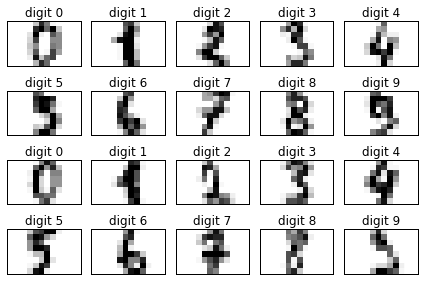

In [4]:
import matplotlib.pyplot as plt
import pylab as pl

num_rows = 4
num_cols = 5

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
ax = ax.flatten()
for index in range(num_rows*num_cols):
    img = digits.images[index]
    label = digits.target[index]
    ax[index].imshow(img, cmap='Greys', interpolation='nearest')
    ax[index].set_title('digit ' + str(label))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Data sets: training versus test

In [5]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 1257, test: 540


In [6]:
import numpy as np

# check to see if the data are well distributed among digits
for y in [y_train, y_test]:
    print(np.bincount(y))

[119 133 128 119 120 135 130 122 128 123]
[59 49 49 64 61 47 51 57 46 57]


## Answer

We first write a scoring function for clustering so that we can use for GridSearchCV.
Take a look at use_scorer under scikit learn.

In [7]:
from sklearn.metrics import accuracy_score, make_scorer
from itertools import permutations

def clustering_accuracy_score(y_true, y_pred):   
    #find how many unique labels exist in y_true and y_cm
    y_cm = y_pred
    index_true = np.unique(y_true)
    index_cm = np.unique(y_cm)
    
    #good is used to find the perfect label for y_cm
    good = [-1] * len(index_cm)
  
    #find the perfect label
    for i in range(len(index_cm)):
        y_true_test = y_true[y_cm == index_cm[i]]
        good[i] = np.argmax(np.bincount(y_true_test))
        
    #modify the index of y_cm to reach consistency with y_true
    good = np.array(good)
    for i in range(len(y_cm)):
        y_cm[i] = good[np.where(index_cm == y_cm[i])][0]
  
    return accuracy_score(y_true = y_true, y_pred = y_cm)    

clustering_accuracy = make_scorer(clustering_accuracy_score) 

In [8]:
# toy case demonstrating the clustering accuracy
# this is just a reference to illustrate what this score function is trying to achieve
# feel free to design your own as long as you can justify

# ground truth class label for samples
toy_y_true = np.array([0, 0, 0, 1, 1, 2])
# clustering id for samples
toy_y_pred_true = np.array([1, 1, 1, 2, 2, 0])
toy_y_pred_bad1 = np.array([0, 0, 1, 1, 1, 2])
toy_y_pred_bad2 = np.array([2, 2, 1, 0, 0, 0])

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_true)
print('accuracy', toy_accuracy, ', should be 1')

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad1)
print('accuracy', toy_accuracy, ', should be', 5.0/6.0)

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad2)
print('accuracy', toy_accuracy, ', should be', 4.0/6.0)

accuracy 1.0 , should be 1
accuracy 0.833333333333 , should be 0.8333333333333334
accuracy 0.833333333333 , should be 0.6666666666666666


For toy_y_pred_bad2, the accuracy I have is different from the accuracy provided. From my point of view, 
y_cm     y_true
0    ->    1
1    ->    0
2    ->    0
Thus, y_cm turns into 0, 0, 0, 1, 1, 1. And the accuracy is 5/6

Build a pipeline with standard scaler, PCA, and clustering.

In [9]:
# your code
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

pipe_clt = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clt', KMeans(n_clusters= 10, tol=1e-04))])


Use GridSearchCV to tune hyper-parameters.

In [10]:
# to see which hyper-parameters can be tuned
pipe_clt.get_params()

{'clt': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'clt__algorithm': 'auto',
 'clt__copy_x': True,
 'clt__init': 'k-means++',
 'clt__max_iter': 300,
 'clt__n_clusters': 10,
 'clt__n_init': 10,
 'clt__n_jobs': 1,
 'clt__precompute_distances': 'auto',
 'clt__random_state': None,
 'clt__tol': 0.0001,
 'clt__verbose': 0,
 'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 2,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'scl': StandardScaler(copy=True, with_mean=True, with_std=True),
 'scl__copy': True,
 'scl__with_mean': True,
 'scl__with_std': True,
 'steps': [('scl', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca',
   PCA(copy

In [11]:
# your code

from sklearn.model_selection import GridSearchCV

# turn on scaling
param_grid1 = {'scl__with_mean': [True],
              'scl__with_std': [True],
              'pca__n_components': np.array(range(1,X.shape[1]+1)),
              'clt__max_iter': [100, 200, 300],
              'clt__n_clusters': np.array(range(10,21))}          

# turn off scaling
param_grid2 = {'scl__with_mean': [False],
              'scl__with_std': [False],
              'pca__n_components': np.array(range(1,X.shape[1]+1)),
              'clt__max_iter': [100, 200, 300],
              'clt__n_clusters': np.array(range(10,21))}   
    
gs1 = GridSearchCV(estimator=pipe_clt,
                  param_grid=param_grid1, 
                  scoring=clustering_accuracy, 
                  cv=10,
                  n_jobs=1,
                  verbose=True
                 )

gs2 = GridSearchCV(estimator=pipe_clt,
                  param_grid=param_grid2, 
                  scoring=clustering_accuracy, 
                  cv=10,
                  n_jobs=1,
                  verbose=True
                 )

# previously, when I just use 1 gs to do the GridSearchCV, the result turns out that StandardScaler(copy=True, with_mean=False, with_std=True)
# which makes no sense... 
# So I use 2 gs to test whether the data should be scaled before clustering
gs1 = gs1.fit(X_train, y_train)
gs2 = gs2.fit(X_train, y_train)        

# below is Li-Yi's dummy code to build a random guess model
import numpy as np
class RandomGuesser:
    def __init__(self, num_classes):
        self.num_classes = num_classes
    def predict(self, X):
        y = np.random.randint(low = 0, high = self.num_classes, size = X.shape[0])
        return y

Fitting 10 folds for each of 2112 candidates, totalling 21120 fits


[Parallel(n_jobs=1)]: Done 21120 out of 21120 | elapsed: 52.6min finished


Fitting 10 folds for each of 2112 candidates, totalling 21120 fits


[Parallel(n_jobs=1)]: Done 21120 out of 21120 | elapsed: 49.4min finished


In [12]:
#best_model = RandomGuesser(10) # replace this with the best model you can build
#test whether with scaling or not performs better
if gs1.best_score_ > gs2.best_score_:
    best_model = gs1.best_estimator_
else:
    best_model = gs2.best_estimator_

print (best_model)

best_model.fit(X_train, y_train)
y_cm = best_model.predict(X_test)

print('Test accuracy: %.3f' % clustering_accuracy_score(y_true=y_test, y_pred=y_cm))

#print('Test accuracy: %.3f' % best_model.score(X_test, y_test))

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=False, with_std=False)), ('pca', PCA(copy=True, iterated_power='auto', n_components=55, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clt', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])
Test accuracy: 0.900


Visualize mis-clustered samples, and provide your explanation.

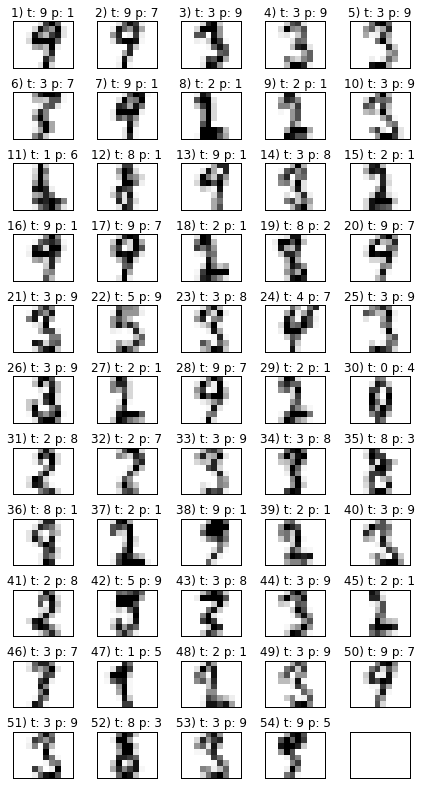

In [13]:
import matplotlib.pyplot as plt
import pylab as pl
import math

mis_img = X_test[y_test != y_cm][:]
correct_label = y_test[y_test != y_cm][:]
mis_label = y_cm[y_test != y_cm][:]

nrow = math.ceil(len(mis_img) / 5)
fig, ax = plt.subplots(nrows=nrow, ncols=5, sharex=True, sharey=True,figsize = (6,nrow))
ax = ax.flatten()
for i in range(len(mis_img)):   
    img = mis_img[i].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_label[i], mis_label[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

your explanation


## Accuracy

My accuracy is around 90%.
Actually, the mis-clustered samples take the form of a mixture of true value and predicted value.Sometimes, it is even difficult for human beings to distinguish and give the correct labels. For example, image36's true value should be 8. However, I cannot tell whether it is 1, 7 or 9, but never 8! Also noteworthy is that the pixels of the datasets are very low. If these samples have a higher resolution, the prediction will be improved without doubt. Furthermore, I use 20 clusters to train the data. The increasing use of the clusters can better catch characteristics of the handwriting of various people. Even for the same number, let's say 7, our writing habit are not the same.

## Data preprocessing

According to GridSearchCV, we don't need to go through standardization for data preprocessing. What we need to go through is dimensionality reduction According to my experiment, PCA of the best model uses 55 components.

# Tiny image classification

We will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) for image object recognition.
The dataset consists of 50000 training samples and 10000 test samples in 10 different classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck; see the link above for more information).
The goal is to maximize the accuracy of your classifier on the test dataset after being optimized via the training dataset.

You can use any learning models (supervised or unsupervised) or optimization methods (e.g. search methods for hyper-parameters).
The only requirement is that your code can run inside an ipynb file, as usual.
Please provide a description of your method, in addition to the code.
Your answer will be evaluated not only on the test accuracy but also on the creativity of your methodology and the quality of your explanation/description.

## Sample code to get you started

This is a difficult classification task.
A sample code below, based on a simple fully connected neural network built via Keras, is provided below.
The test accuracy is about 43%.

In [14]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,keras

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


Using TensorFlow backend.


last updated: 2016-12-05 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.2
keras 1.1.1


In [15]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
import numpy as np
from sklearn.metrics import accuracy_score

# load data set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

img_shape = X_train.shape[1:] # [num_rows, num_cols, num_channels]
num_img_pixels = np.prod(img_shape)
num_training_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

nb_classes = np.sum(np.unique(y_train).shape)

print('image shape: ', img_shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')
print(nb_classes, 'classes')

# data processing

X_train = X_train.reshape(num_training_samples, num_img_pixels)
X_test = X_test.reshape(num_test_samples, num_img_pixels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one hot encoding of labels
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

image shape:  (32, 32, 3)
50000 training samples
10000 test samples
10 classes


In [3]:
# build a basic network

model = Sequential()

model.add(Dense(input_dim = num_img_pixels, 
                output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))

model.add(Dense(output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))

model.add(Dense(output_dim = nb_classes, 
                init = 'uniform', 
                activation = 'softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)

model.compile(loss = 'categorical_crossentropy', 
              optimizer = sgd, 
              metrics = ["accuracy"])


In [4]:
# train

_ = model.fit(X_train, y_train_ohe, 
              nb_epoch = 5, 
              batch_size = 10, 
              verbose = False, # turn this on to visualize progress 
              validation_split = 0.1 # 10% of training data for validation per epoch
             )

In [5]:
# evaluate

y_train_pred = model.predict_classes(X_train, verbose=False)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model.predict_classes(X_test, verbose=False)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)


First few predictions:  [6 1 9]
Training accuracy: 0.43282
Test accuracy: 0.4304


## Answer

In [1]:
# your code and experimental results
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD
import numpy as np
from sklearn.metrics import accuracy_score

# load data set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

img_shape = X_train.shape[1:] # [num_rows, num_cols, num_channels]
num_img_pixels = np.prod(img_shape)
num_training_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

nb_classes = np.sum(np.unique(y_train).shape)

print('image shape: ', img_shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')
print(nb_classes, 'classes')

# data processing

#X_train = X_train.reshape(num_training_samples, num_img_pixels)
#X_test = X_test.reshape(num_test_samples, num_img_pixels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one hot encoding of labels
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

Using TensorFlow backend.


image shape:  (32, 32, 3)
50000 training samples
10000 test samples
10 classes


In [2]:
from __future__ import print_function
from keras import backend as K
# Orthonorm init code is taked from Lasagne
# https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
def svd_orthonormal(shape):
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations

def LSUVinit(model,batch):
    margin = 0.1
    max_iter = 10
    i=-1
    for layer in model.layers:
        i+=1
        print(layer.get_config()['name'])
        if (('convolution' not in layer.get_config()['name']) and 'clf' not in layer.get_config()['name'] and 'dense' not in layer.get_config()['name']):
            continue
        w_all=layer.get_weights();
        weights = np.array(w_all[0])
        weights = svd_orthonormal(weights.shape)
        biases = np.array(w_all[1])
        w_all_new = [weights,biases]
        layer.set_weights(w_all_new)
        acts1=get_activations(model,i,batch)
        var1=np.var(acts1)
        iter1=0
        needed_variance = 1.0
        print(var1)
        while (abs(needed_variance - var1) > margin):
            w_all=layer.get_weights();
            weights = np.array(w_all[0])
            biases = np.array(w_all[1])
            weights /= np.sqrt(var1)/np.sqrt(needed_variance)
            w_all_new = [weights,biases]
            layer.set_weights(w_all_new)
            acts1=get_activations(model,i,batch)
            var1=np.var(acts1)
            iter1+=1
            print(var1)
            if iter1 > max_iter:
                break
    return model

In [3]:
#2nd best model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(80, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(80, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)

model.compile(loss = 'categorical_crossentropy', 
              optimizer = sgd, 
              metrics = ["accuracy"])

batch_size = 128
model = LSUVinit(model,X_train[:batch_size,:,:,:]) 

convolution2d_1
0.0298732
1.0
activation_1
convolution2d_2
0.0500271
1.0
activation_2
convolution2d_3
0.0386222
1.0
activation_3
maxpooling2d_1
dropout_1
convolution2d_4
0.0237685
1.0
activation_4
convolution2d_5
0.0196425
1.0
activation_5
maxpooling2d_2
dropout_2
convolution2d_6
0.0118312
1.0
activation_6
convolution2d_7
0.0103933
1.0
activation_7
convolution2d_8
0.00914927
1.0
activation_8
averagepooling2d_1
dropout_3
flatten_1
dense_1
0.113806
1.0
activation_9
dropout_4
dense_2
0.274083
1.0
activation_10


In [4]:
# train

_ = model.fit(X_train, y_train_ohe, 
              nb_epoch = 200, 
              verbose = True, # turn this on to visualize progress 
              validation_split = 0.1 # 10% of training data for validation per epoch
             )

Train on 45000 samples, validate on 5000 samples
Epoch 1/200
45000/45000 [==============================] - 228s - loss: 2.2101 - acc: 0.1540 - val_loss: 2.1479 - val_acc: 0.1620
Epoch 2/200
45000/45000 [==============================] - 229s - loss: 1.9960 - acc: 0.2050 - val_loss: 1.9828 - val_acc: 0.2316
Epoch 3/200
45000/45000 [==============================] - 229s - loss: 1.8980 - acc: 0.2509 - val_loss: 1.8847 - val_acc: 0.2970
Epoch 4/200
45000/45000 [==============================] - 229s - loss: 1.8015 - acc: 0.3020 - val_loss: 1.8766 - val_acc: 0.3312
Epoch 5/200
45000/45000 [==============================] - 232s - loss: 1.7082 - acc: 0.3517 - val_loss: 1.6738 - val_acc: 0.3970
Epoch 6/200
45000/45000 [==============================] - 231s - loss: 1.6436 - acc: 0.3811 - val_loss: 1.7814 - val_acc: 0.3678
Epoch 7/200
45000/45000 [==============================] - 231s - loss: 1.5916 - acc: 0.4068 - val_loss: 1.5480 - val_acc: 0.4360
Epoch 8/200
45000/45000 [================

In [5]:
# evaluate

y_train_pred = model.predict_classes(X_train, verbose=True)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model.predict_classes(X_test, verbose=True)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)

50000/50000 [==============================] - 86s    
First few predictions:  [6 9 9]
Training accuracy: 0.94348
10000/10000 [==============================] - 17s    
Test accuracy: 0.8339


In [7]:
#best model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(80, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(80, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)

model.compile(loss = 'categorical_crossentropy', 
              optimizer = sgd, 
              metrics = ["accuracy"])

batch_size = 128
model = LSUVinit(model,X_train[:batch_size,:,:,:]) 

convolution2d_9
0.0257019
1.0
activation_11
convolution2d_10
0.0280275
1.0
activation_12
maxpooling2d_3
dropout_5
convolution2d_11
0.019394
1.0
activation_13
convolution2d_12
0.02157
1.0
activation_14
maxpooling2d_4
dropout_6
convolution2d_13
0.0152608
1.0
activation_15
convolution2d_14
0.0114568
1.0
activation_16
averagepooling2d_2
dropout_7
flatten_2
dense_3
0.123782
1.0
activation_17
dropout_8
dense_4
0.416896
1.0
activation_18


In [8]:
# train

_ = model.fit(X_train, y_train_ohe, 
              nb_epoch = 200, 
              verbose = True, # turn this on to visualize progress 
              validation_split = 0.1 # 10% of training data for validation per epoch
             )

Train on 45000 samples, validate on 5000 samples
Epoch 1/200
45000/45000 [==============================] - 188s - loss: 2.2762 - acc: 0.1377 - val_loss: 2.1663 - val_acc: 0.1968
Epoch 2/200
45000/45000 [==============================] - 189s - loss: 2.0679 - acc: 0.1958 - val_loss: 1.9274 - val_acc: 0.2284
Epoch 3/200
45000/45000 [==============================] - 189s - loss: 1.9046 - acc: 0.2484 - val_loss: 1.9463 - val_acc: 0.2518
Epoch 4/200
45000/45000 [==============================] - 188s - loss: 1.8130 - acc: 0.2861 - val_loss: 1.7168 - val_acc: 0.3300
Epoch 5/200
45000/45000 [==============================] - 188s - loss: 1.7293 - acc: 0.3224 - val_loss: 1.6462 - val_acc: 0.3714
Epoch 6/200
45000/45000 [==============================] - 189s - loss: 1.6520 - acc: 0.3606 - val_loss: 1.5845 - val_acc: 0.3988
Epoch 7/200
45000/45000 [==============================] - 188s - loss: 1.5881 - acc: 0.3894 - val_loss: 1.6027 - val_acc: 0.4062
Epoch 8/200
45000/45000 [================

In [9]:
# evaluate

y_train_pred = model.predict_classes(X_train, verbose=True)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model.predict_classes(X_test, verbose=True)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)

50000/50000 [==============================] - 73s    
First few predictions:  [6 9 9]
Training accuracy: 0.91238
10000/10000 [==============================] - 14s    
Test accuracy: 0.8398


## Your description
with the following main parts:

<dl>

<dt>Introduction</dt>
<dd>
At a high-level, what are the approaches you considered and why?
</dd>

<dt>Method</dt>
<dd>
Describe your entire pipeline, such as data-preprocessing, model selection, and hyper-parameter optpimization.
</dd>

<dt>Results</dt>
<dd>
Describe the experimental process you took to arrive at the solution.
For example:
(1) compare your approach against other approach(es) you have tried, as
well as the MLP baseline classifer.
(2) compare against different settings of model parameters, e.g. regularization type/strength, number of hidden units or structure of a neural network, types of kernel in a SVM, etc. 

<dt>Conclusion</dt>
<dd>
Summarize what you have learned from the experiments and discuss the limitations and potential future improvements of your current method.
</dd>

<dt>References</dt>
<dd>
Cite any publically available code, blog posts, research papers, etc. you used or got ideas from.
</dl>

## Introduction

I consider using CNN to train my data. Since CNN is sparser and implicitly regularized than MLP. With the aid of CNN, I can go deeper into the analysis.

## Method

I use LAYER-SEQUENTIAL UNIT-VARIANCE INITIALIZATION (LSUV) method to process(initialize) my data. Basically speaking, the method is made up of two steps. First, pre-initialize weights of each convolution or inner-product layer with orthonormal matrices and Gaussian noise with unit variance. Decompose the weights to orthonormal basis with QR or SVDdecomposition and replace them.  Second, normalize the variance of the output of each layer to be equal to one. This method can be considered as an orthonormal initialization combined with batch normalization performed only on the first mini-batch. It is said the initial orthonormalization of weights efficiently de-correlates layer activations and relevant experiments also show that such operation is of high efficiency compared with full batch normalization.

For the layer, I referred to "FitNet-4" structure. Since it is said LSUV works quite well under this architecture according to the paper. However, I simplified the structure quite a lot to gain a rough idea and most importantly, to save time. 

Stage 1, 32*3*3 Convolution twice, a 2*2 MaxPooling and a Dropout(0.5)

Stage 2, 80*3*3 Convolution twice, a 2*2 MaxPooling and a Dropout(0.5)

Stage 3, 128*3*3 Convolution twice, a 4*4 AveragePooling and a Dropout(0.5)

Stage 4, flatten, dense, a Dropout(0.5) and softmax

## Results

I made quite a lot of experiments regarding this question. 
#### 1. Randomly use a model through internet to gain some insights. The dropout is 0.25.  
    Model can be referred at https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py  
    Unfortunately, I lost the training accuracy and test accuracy...  
    But mark down that the training accuracy was quite high while the test accuracy was quite low.  
    Seems like an issues of overfitting.  
    
#### 2. Randomly use a model through internet to gain some insights. The dropout is 0.25.  
    Model can be referred at https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py  
    This time, I added the LSUV to process the data.  
    Training accuracy of the first few predictions is 0.90696, while the test accuracy is 0.8033.  
    Both accuracies were higher than first trial. Seems like LSUV works.  
    Still an issues of overfitting.
    
#### 3.  Use a simplified FitNet-4. Use LSUV. The dropout is 0.5.

    Stage 1, 32*3*3 Convolution twice, a 2*2 MaxPooling and a Dropout(0.5)
    
    Stage 2, 80*3*3 Convolution twice, a 2*2 MaxPooling and a Dropout(0.5)
    
    Stage 3, 128*3*3 Convolution twice, a 4*4 AveragePooling and a Dropout(0.5)
    
    Stage 4, flatten, dense, a Dropout(0.5) and softmax
    
    Model can be referred at https://arxiv.org/pdf/1511.06422v7.pdf  
    Training accuracy of the first few predictions is 0.91238, while the test accuracy is 0.8398.  
    Test accuracy was higher than previous trial.Seems like FitNet-4 works.  
    Issue of overfitting gets improvement.
    
#### 4. Use a simplified FitNet-4. Use LSUV. The dropout is 0.5.

    Stage 1, 32*3*3 Convolution twice, 48*3*3 Convolution once, a 2*2 MaxPooling and a Dropout(0.5)
    
    Stage 2, 80*3*3 Convolution twice, a 2*2 MaxPooling and a Dropout(0.5)
    
    Stage 3, 128*3*3 Convolution twice, a GlobalMaxPooling and a Dropout(0.5)
    
    Stage 4, dense, a Dropout(0.5) and softmax
    
    Model can be referred at https://arxiv.org/pdf/1511.06422v7.pdf  
    Didn't finish the training. According to the observation for the first 20 epochs, the training efficiency was quite low.  
    For the third trial, val_acc: 0.6588  
    For this trial, val_acc: 0.1964  
    I suppose the reason behind that is the use of GlobalMaxPooling, which is for spatial data. According to FitNet-4, global pooling should be applied at the last step. However, since my simplified model structure did not consist so many layers, thus the data after processed  was not that sparse. Thus, I decide that GlobalMaxPooling should not be adopted in my model.

#### 5. Use a simplified FitNet-4. But add several more layers compared to the one of the third trial. Use LSUV. The dropout is 0.5.

    Stage 1, 32*3*3 Convolution trice, a 2*2 MaxPooling and a Dropout(0.5)
    
    Stage 2, 80*3*3 Convolution twice, a 2*2 MaxPooling and a Dropout(0.5)
    
    Stage 3, 128*3*3 Convolution trice, a 2*2 AveragePooling and a Dropout(0.5)
    
    Stage 4, flatten, dense, a Dropout(0.5) and softmax
    
    Model can be referred at https://arxiv.org/pdf/1511.06422v7.pdf  
    Training accuracy of the first few predictions is 0.94348, while the test accuracy is 0.8339.  
    Test accuracy is almost the same compared to the third trial. However, the training accuracy is too high.  
    Issue of overfitting.
   

## Conclusion

The third and the fifth trial perform the best among what I have tried. Compared to the third model, the fifth one has more layers and is more complicated. The time to train the data using this model is also higher as expected. However, the result of test accuracy is not as high as the third one. Therefore, I consider the third model to be the best, due to less training time and higher test accuracy. I learn from the experiment that test accuracy won't definitely increase along with the number of layers used in the model. And the issue of overfitting should be fixed so as to improve the test accuracy. I also acquire some information from other papers that Bayesian Optimization can be used to process the data and improve the training result (https://arxiv.org/pdf/1502.05700v2.pdf). Maybe I can combine the Bayesian Optimization into my model next time. 


## References
1. <fchollet/keras> https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
2. <ALL YOU NEED IS A GOOD INIT> https://arxiv.org/pdf/1511.06422v7.pdf
3. <Scalable Bayesian Optimization Using Deep Neural Networks> https://arxiv.org/pdf/1502.05700v2.pdf
4. <ducha-aiki/LSUV-keras> https://github.com/ducha-aiki/LSUV-keras  
    @ARTICLE{LSUVInit2015,
    author = {{Mishkin}, D. and {Matas}, J.},
    title = "{All you need is a good init}",
    journal = {arXiv preprint arXiv:1511.06422},
    year = 2015,
    month = nov
    }